In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

import datetime
from os import listdir
from os.path import isfile, join
import glob
import re

import statsmodels.formula.api as smf
from fancyimpute import MICE


#read data set into a pandas dataframe
df = pd.read_csv('~/Documents/Repository/Capstone-1_WorldBank_GenderData/Data.csv')

In [2]:
df.head(2)

,Country.Name,Country.Code,Indicator.Name,Indicator.Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Arab World,ARB,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,3.585854,5.611509,7.350393,8.645366,10.059527,12.358258,15.225028,17.751386,21.102336,NaN
1,Arab World,ARB,"Access to anti-retroviral drugs, male (%)",SH.HIV.ARTC.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4.407830,6.393077,7.520210,9.119101,10.627401,11.652603,13.841550,15.956337,18.406402,NaN


In [3]:
# Melting the individual years columns to be one column with the individual years as rows
id_vars = ["Country.Name",
           "Country.Code",
           "Indicator.Name",
          "Indicator.Code"]

dfmelt = pd.melt(frame=df,id_vars=id_vars, var_name="year", value_name="value")

# Formatting 
dfmelt["year"] = dfmelt["year"].str.extract('(\d+)', expand=False).astype(int)
dfmelt["value"] = dfmelt["value"].astype(float)

# Cleaning out unnecessary rows with empty values
dfmelt = dfmelt.dropna()

dfmelt = dfmelt[["Country.Name",
         "Country.Code",
         "Indicator.Name",
         "Indicator.Code",
         "year",
         "value"]]

dfmelt = dfmelt.sort_values(ascending=True, by=["Country.Name","Indicator.Name","year"])

In [4]:
dfmelt.head()

,Country.Name,Country.Code,Indicator.Name,Indicator.Code,year,value
7269408,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2000,0.0
7450352,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2001,0.0
7631296,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2002,0.0
7812240,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2003,0.0
7993184,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2004,0.0


In [5]:
#Find out which years have the least # of missing values
dfmelt.year.value_counts().sort_values(ascending =False).head(16)

2011    47985
2014    44370
2010    42365
2012    41820
2000    39529
2009    37999
2013    37871
2005    37647
2007    36995
2006    36756
2008    36748
2004    34423
2002    33683
2003    33428
2001    33347
1999    31201
Name: year, dtype: int64

In [6]:
#restrict the data to years between 1999 and 2015
df2k = dfmelt[(dfmelt.year > 1999) & (dfmelt.year<2015)]
df2k.head()

,Country.Name,Country.Code,Indicator.Name,Indicator.Code,year,value
7269408,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2000,0.0
7450352,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2001,0.0
7631296,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2002,0.0
7812240,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2003,0.0
7993184,Afghanistan,AFG,"Access to anti-retroviral drugs, female (%)",SH.HIV.ARTC.FE.ZS,2004,0.0


In [7]:
# Unmelting/unstacking column "Indictor.Name" to make each 'indicator' variable its own row
dfvars = df2k.pivot_table(index=["Country.Name","year"], columns="Indicator.Name", values="value")
dfvars.reset_index(drop=False, inplace=True)

In [8]:
dfvars.head(10)

Indicator.Name,Country.Name,year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land both alone and jointly (% of women age 15-49): Q3,Women who own land both alone and jointly (% of women age 15-49): Q4,Women who own land both alone and jointly (% of women age 15-49): Q5 (highest),Women who own land jointly (% of women age 15-49),Women who own land jointly (% of women age 15-49): Q1 (lowest),Women who own land jointly (% of women age 15-49): Q2,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24)
0,Afghanistan,2000,0.0,0.0,NaN,NaN,153.8456,NaN,NaN,103.254202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2001,0.0,0.0,NaN,NaN,150.0468,NaN,NaN,102.933042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2002,0.0,0.0,NaN,NaN,146.2480,NaN,NaN,102.217020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2003,0.0,0.0,NaN,NaN,140.4764,NaN,NaN,101.290161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2004,0.0,0.0,NaN,NaN,134.7048,NaN,NaN,100.247559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Afghanistan,2005,0.0,0.0,NaN,NaN,128.9332,NaN,NaN,99.078444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Afghanistan,2006,0.0,0.0,NaN,NaN,123.1616,NaN,NaN,99.574274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Afghanistan,2007,0.0,0.0,NaN,NaN,117.3900,NaN,NaN,100.000371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Afghanistan,2008,0.0,0.0,NaN,NaN,111.4708,15.0,25.3,100.215886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
9,Afghanistan,2009,1.0,0.0,NaN,NaN,105.5516,NaN,NaN,100.060480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


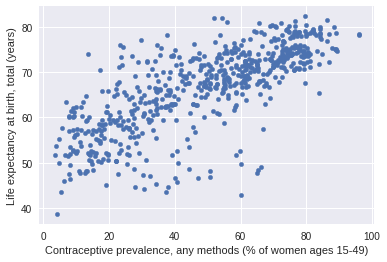

In [9]:
dfvars.plot(x = 'Contraceptive prevalence, any methods (% of women ages 15-49)', y ='Life expectancy at birth, total (years)', kind = 'scatter')

In [10]:
dfvars.to_csv('wrangled_data.csv')

In [11]:
#create a new df with fewer variables to build models with
focus = pd.DataFrame()
focus['country'] = dfvars['Country.Name']
focus['life'] = dfvars['Life expectancy at birth, total (years)']
focus['bc'] = dfvars['Contraceptive prevalence, any methods (% of women ages 15-49)']
focus['matdeath'] = dfvars['Maternal mortality ratio (modeled estimate, per 100,000 live births)']
focus['teen'] = dfvars['Adolescent fertility rate (births per 1,000 women ages 15-19)']
focus['gdp'] = dfvars['GDP per capita (Current US$)']
focus['healthspend'] = dfvars['Health expenditure, public (% of GDP)']
focus['eduspend'] = dfvars['Public spending on education, total (% of GDP)']

focus.to_csv('finalvars.csv')

In [12]:
focus.head()

,country,life,bc,matdeath,teen,gdp,healthspend,eduspend
0,Afghanistan,55.125878,4.9,1100.0,153.8456,NaN,NaN,NaN
1,Afghanistan,55.487537,NaN,1050.0,150.0468,119.899037,NaN,NaN
2,Afghanistan,55.857195,NaN,996.0,146.2480,192.153528,0.550723,NaN
3,Afghanistan,56.235293,10.3,941.0,140.4764,203.651041,0.607900,NaN
4,Afghanistan,56.626317,NaN,881.0,134.7048,224.914712,0.969459,NaN


In [13]:
#count non-NaN rows in each column
focus.count()

country        3945
life           3699
bc              639
matdeath       3435
teen           3600
gdp            3644
healthspend    3523
eduspend       2100
dtype: int64

In [14]:
#split data into "Causes" and "Effects" of Contraceptive Use
dfcause = focus[['bc', 'gdp', 'healthspend', 'eduspend']]
dfeffect = focus[['country', 'bc', 'life', 'matdeath', 'teen']]

#count non-NaN values in "Cause" df
dfcause.dropna().count()

bc             370
gdp            370
healthspend    370
eduspend       370
dtype: int64

In [15]:
#Count non-NaN rows in "Effect" df
dfeffect.dropna().count()

country     624
bc          624
life        624
matdeath    624
teen        624
dtype: int64

In [16]:
#save "Effect" df without NaN rows because there are very few rows with NaNs
effect = dfeffect.dropna()

In [17]:
#drop rows in "Cause" df where Contraceptive Use is NaN
dfcause = dfcause[np.isfinite(dfcause['bc'])]

### Using Fancy Impute to interpolate NaN values in the "Causes" df because just dropping them eliminates too much data. The MICE algorithm was chosen because its method looks at each values rather than just a blanketed approach.

In [18]:
micefilled = MICE().complete(dfcause)

[MICE] Completing matrix with shape (639, 4)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.016
[MICE] Starting imputation round 3/110, elapsed time 0.018
[MICE] Starting imputation round 4/110, elapsed time 0.019
[MICE] Starting imputation round 5/110, elapsed time 0.020
[MICE] Starting imputation round 6/110, elapsed time 0.043
[MICE] Starting imputation round 7/110, elapsed time 0.046
[MICE] Starting imputation round 8/110, elapsed time 0.048
[MICE] Starting imputation round 9/110, elapsed time 0.051
[MICE] Starting imputation round 10/110, elapsed time 0.053
[MICE] Starting imputation round 11/110, elapsed time 0.055
[MICE] Starting imputation round 12/110, elapsed time 0.082
[MICE] Starting imputation round 13/110, elapsed time 0.086
[MICE] Starting imputation round 14/110, elapsed time 0.091
[MICE] Starting imputation round 15/110, elapsed time 0.097
[MICE] Starting imputation round 16/110, elapsed time 0.099
[MIC

In [19]:
mice = pd.DataFrame(micefilled, columns = dfcause.columns)
mice.head()

,bc,gdp,healthspend,eduspend
0,4.9,-1443.568622,2.833285,4.096969
1,10.3,203.651041,0.607900,4.066009
2,13.6,257.175795,0.801919,4.127794
3,18.6,280.245644,1.062420,3.821914
4,22.8,384.131681,1.385584,4.286720


The MICE algorithm seems to have interpolated mostly logical values, however there are a couple values for GPD that were interpolated to be negative numbers. As negative numbers do not make sense in this context, these values are replaced with their absolute value

In [20]:
cause = mice.abs()

In [21]:
cause.head()

,bc,gdp,healthspend,eduspend
0,4.9,1443.568622,2.833285,4.096969
1,10.3,203.651041,0.607900,4.066009
2,13.6,257.175795,0.801919,4.127794
3,18.6,280.245644,1.062420,3.821914
4,22.8,384.131681,1.385584,4.286720


In [22]:
#correcting interpolation error of first interpolated value (substituted with next available value)
cause.gdp[0] = 119

### Next cell not re-run, because re-running MICE changed interpolated values, which could affect Machine Learning outcomes. Below is the original data used to build models for this project.

In [66]:
#convert to csv for future use
cause.to_csv('causes.csv')
effect.to_csv('effects.csv')